In [1]:
import glob
import re
import os
from collections import Counter
import numpy as np
from tqdm import tqdm
import sentencepiece as spm
from matplotlib import pyplot as plt

In [3]:
pwd

'/Users/mccullen/Dropbox/python/biotokens'

In [4]:
# removing spaces from book, The Golden Bough
with open('data/golden_bough.txt','r') as f:
    corpus = f.read()
    
corpus=corpus.split('Gutenberg')[5].split('EBOOK')[1]

sents = re.sub('[^a-zA-Z\.]','',corpus.lower()).split('.')
with open('data/goldenbough.txt','w') as f:
    f.write('\n'.join(sents))

In [96]:
# displaying 20 random sentences
np.random.choice(sents,20)

array(['assomepeoplethinktheycanlightupthesunorspeedhimonhiswaysoothersfancytheycanretardorstophim',
       'thenatureofosiris',
       'iffromsicknessoranyothercausehewasunabletodischargethisdutyforthreewholedayshewashangedonthetreeinanoosewhichcontainedtworazorssoarrangedthatwhenthenoosewasdrawntightbytheweightofthekingsbodytheycuthisthroat',
       'theinterpretationofthefirefestivals',
       'whyisthisandwhyinparticularshouldamanbethoughttostunthisgrowthbyutteringhisownnamewemayconjecturethattosavageswhoactandthinkthusapersonsnameonlyseemstobeapartofhimselfwhenitisutteredwithhisownbreathutteredbythebreathofothersithasnovitalconnexionwithhimandnoharmcancometohimthroughit',
       'amongtheyorubanegroesofwestafricathehumanvictimchosenforsacrificeandwhomaybeeitherafreebornoraslaveapersonofnobleorwealthyparentageoroneofhumblebirthisafterhehasbeenchosenandmarkedoutforthepurposecalledanoluwo',
       'eatyourshareandmakeallthepeopleinthevillagewell',
       'hiswholebeingbodyandsoulisso

In [ ]:
# training tokenizer
spms = f'''--input=data/goldenbough.txt 
--model_prefix=sentencepiece/goldenbough 
--vocab_size=5000'''.replace('\n','')

spm.SentencePieceTrainer.train(spms)

In [98]:
# saving first 500 tokens for manual review
dfgb=pd.read_csv('sentencepiece/goldenbough.vocab',sep='\t',
            header=None)

with open('goldenbough500.tsv','w') as f:
    f.write('\n'.join(dfgb[0][3:504]+'\t'))

In [124]:
# opening manually reviewed tokens
dfg = pd.read_csv('goldenbough500.tsv',
            sep='\t',header=None)

dfg.columns=['token','clas']
dfg.clas = dfg.apply(lambda D: 'b' if (len(D.token)==2 and D.clas=='x') else D.clas,axis=1)

dfg.clas.value_counts().values

array([296,  68,  58,  26,  21,  21,   8,   1])

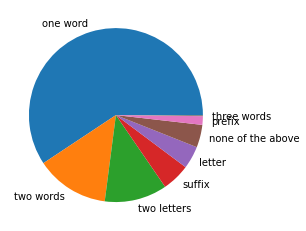

In [125]:
# manual classification of first 500 tokens
leg={'1': 'one word',
'2': 'two words',
'3': 'three words',
'l': 'letter',
's': 'suffix',
'p': 'prefix',
'x': 'none of the above',
'b':'two letters'}
C = dfg.clas.value_counts()

plt.pie(C.values,
        labels=[leg[i] for i in C.index])
plt.show()

In [5]:
# tokenization of example sentences
from matplotlib import pyplot as plt
sp = spm.SentencePieceProcessor(model_file='sentencepiece/goldenbough.model')
sent = 'thereforewhenamanoranimalisseenboldlytoappropriatethesacredfirstfruitsheoritisnaturallyregardedasthedivinityhimselfinhumanoranimalformtakingpossessionofhisown'


print(' '.join(sp.encode_as_pieces(sent)[1:]))



therefore when aman or animal is seen b old ly to appropriate thesacred firstfruit she or itis naturally regardedas the divinity himself in human or animal form taking possessionof hisown


In [7]:
sent='therefore when aman or animal is seen b old ly to appropriate thesacred firstfruit she or itis naturally regardedas the divinity himself in human or animal form taking possessionof hisown'
sp.encode_as_pieces(sent)[1:]


['therefore',
 '▁when',
 '▁',
 'aman',
 '▁',
 'or',
 '▁',
 'animal',
 '▁',
 'is',
 '▁',
 'seen',
 '▁',
 'b',
 '▁',
 'old',
 '▁',
 'ly',
 '▁',
 'to',
 '▁',
 'appropriate',
 '▁',
 'thesacred',
 '▁',
 'firstfruit',
 '▁',
 'she',
 '▁',
 'or',
 '▁itis',
 '▁',
 'naturally',
 '▁',
 'regardedas',
 '▁the',
 '▁',
 'divinity',
 '▁',
 'himself',
 '▁in',
 '▁',
 'human',
 '▁',
 'or',
 '▁',
 'animal',
 '▁',
 'form',
 '▁',
 'taking',
 '▁',
 'possessionof',
 '▁',
 'hisown']

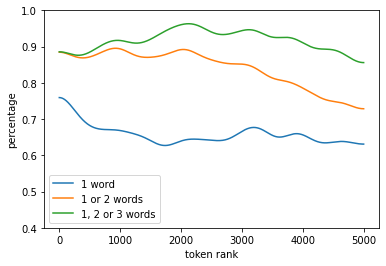

(0.658, 0.84, 0.917)

In [197]:
# determining how many tokens are words/bigrams/trigrams from book vocab
from scipy.ndimage import gaussian_filter

words = re.sub('[^a-zA-Z]',' ',corpus.lower())
words = words.split()
bigrams = [w+z for w,z in zip(words[:-1],words[1:])]
trigrams = [w+y+z for w,y,z in 
            zip(words[:-2],words[1:-1],words[2:])]

words = set(words)
bigrams = words|set(bigrams)
trigrams = bigrams|set(trigrams)

toks = dfgb[0][3:].tolist()
in1s = [float(t.replace('▁','') in words) for t in toks]
in2s = [float(t.replace('▁','') in bigrams) for t in toks]
in3s = [float(t.replace('▁','') in trigrams) for t in toks]

plt.plot(gaussian_filter(in1s,sigma=200),label='1 word')
plt.plot(gaussian_filter(in2s,sigma=200),label='1 or 2 words')
plt.plot(gaussian_filter(in3s,sigma=200),label='1, 2 or 3 words')
plt.ylim(.4,1)
plt.xlabel('token rank')
plt.ylabel('percentage')
plt.legend()
plt.show()
np.round(np.mean(in1s),3),\
np.round(np.mean(in2s),3),\
np.round(np.mean(in3s),3)

In [194]:
# first 20 tokens in bigrams
[t for t in toks 
 if t.replace('▁','') not in words
 and t.replace('▁','') in bigrams][:20]



['ofthe',
 'inthe',
 'tothe',
 'onthe',
 'itis',
 'tobe',
 'fromthe',
 'ina',
 'andthe',
 'bythe',
 'im',
 'asa',
 'withthe',
 'forthe',
 'thatthe',
 'ofa',
 'thesame',
 'itwas',
 'atthe',
 'allthe']

In [ ]:
# tokens not in trigrams
[t for t in toks if t.replace('▁','') not in trigrams]

In [13]:
# removing spaces from book, The Golden Bough
from utils.tokenizer_utils import train_sentencepiece_tokenizer, compression_ratio

with open('data/golden_bough.txt','r') as f:
    corpus = f.read()
    
corpus=corpus.split('Gutenberg')[5].split('EBOOK')[1]

sents = corpus.lower().split('.')
sents = [s+'.' for s in sents]
with open('data/goldenbough_punc.txt','w') as f:
    f.write('\n'.join(sents))

In [ ]:
train_sentencepiece_tokenizer('data/goldenbough_punc.txt', 
                              'tokenizers/goldenbough_punc', 
                              10000)

In [24]:
import pandas as pd
tokenizer = spm.SentencePieceProcessor(model_file='tokenizers/goldenbough_punc.model')
toks = []
for t in tokenizer.encode(sents):
    toks+=t

with open('tokenizers/goldenbough_punc.vocab','r') as f:
    vocab = f.read().split('\n')
    
vocab = [v.split('\t')[0].replace('▁','') for v in vocab]
#vocab = vocab[0].tolist()

In [91]:
def compression_ratio2(genome,tokens,vocab):
    genome_len = len(genome)
    stokens=set(tokens)
    vocab_len = sum([len(v)+1 for e,v in enumerate(vocab) if e in stokens])-1
    #sequence_len = len(' '.join([str(tok2up[i]) for i in tokens]))
    sequence_len = len(' '.join([str(i) for i in tokens]))
    sequence_len = len(tokens)*2
    #sequence_len = len(' '.join([hex(i)[2:] for i in tokens]))
    return vocab_len,sequence_len,genome_len,\
    (vocab_len+sequence_len)/genome_len

compression_ratio2('\n'.join(sents),toks,vocab)

(61807, 1000198, 2287754, 0.4642129354816995)

In [87]:
len(toks),len(' '.join([str(i) for i in toks]))

(500099, 1972909)

In [76]:
#A->00, C->01, G->10, T->11
int('11011000',2)
chr(int('11011000',2))

import lzma

lzma.compress(b'af'*80)

b'\xfd7zXZ\x00\x00\x04\xe6\xd6\xb4F\x02\x00!\x01\x16\x00\x00\x00t/\xe5\xa3\xe0\x00\x9f\x00\x08]\x000\x99\xaa0\x10\x00\x00\x00\x00\x83\xb0v6\xda\x04\x13c\x00\x01$\xa0\x01\x00\x00\x00\x0ek\xf3\x97\xb1\xc4g\xfb\x02\x00\x00\x00\x00\x04YZ'

In [79]:
book = '\n'.join(sents)
compressed_book = lzma.compress(bytes(book,'utf-8'))

In [80]:
len(compressed_book)/len(book)

0.28370008313830947

In [98]:
len(set(book))/256

0.30078125

In [95]:
from utils.tokenizer_utils import train_sentencepiece_tokenizer, compression_ratio

with open('data/islandlife.txt','r') as f:
    corpus = f.read()
    
#corpus=corpus.split('Gutenberg')[5].split('EBOOK')[1]

sents = corpus.lower().split('.')
sents = [s+'.' for s in sents]
with open('data/islandlife_punc.txt','w') as f:
    f.write('\n'.join(sents))
    
#train_sentencepiece_tokenizer('data/islandlife_punc.txt', 
#                              'tokenizers/islandlife_punc', 
#                              10000)
with open('tokenizers/islandlife_punc.vocab','r') as f:
    vocab2 = f.read().split('\n')
    
vocab2 = [v.split('\t')[0].replace('▁','') for v in vocab2]

slope 0.7109840294640762
intercept -2.222723175289583
r_value 0.721591190668108
p_value 0.0
std_err 0.011221939004979184


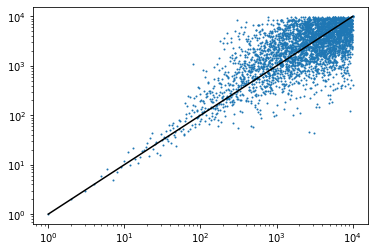

In [96]:
from scipy import stats
V = list(set(vocab)&set(vocab2))
V1 = [vocab.index(v)+1 for v in V]
V2 = [vocab2.index(v)+1 for v in V]
slope, intercept, r_value, p_value, std_err = stats.linregress(
                            -np.log(V1),-np.log(V2))
ns = 'slope, intercept, r_value, p_value, std_err'.split(', ')
for n,x in zip(ns, [slope, intercept, r_value, p_value, std_err]):
    print(n,x)
    
plt.scatter(V1,V2,s=1)
plt.xscale('log')
plt.yscale('log')
plt.plot([1,10**4],[1,10**4],c='black')

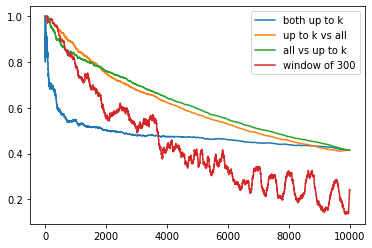

0.4153465902707561

In [97]:
def ov(l1,l2):
    s1, s2 = set(l1),set(l2)
    return len(s1&s2)/min(len(s1),len(s2))

plt.plot([ov(vocab[:k],vocab2[:k]) 
          for k in range(1,len(vocab))],label='both up to k')
plt.plot([ov(vocab[:k],vocab2) 
          for k in range(1,len(vocab))],label='up to k vs all')
plt.plot([ov(vocab,vocab2[:k]) 
          for k in range(1,len(vocab))],label='all vs up to k')
plt.plot([ov(vocab[max(0,k-300):k],vocab2) 
          for k in range(1,len(vocab))],label='window of 300')
plt.legend()
plt.show()
ov(vocab,vocab2)